# 캐글 참여 링크

https://www.kaggle.com/t/05f287fe67bb43298d8c3e66a1e71c27

# House Prices 🏠

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv('/content/train.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,968,20,RL,NaN,7390,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,135000
1,739,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Alloca,179000
2,696,20,RL,54.0,13811,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,176000


# 1.데이터 전처리

### 1-1.데이터 컬럼 type 확인

In [77]:
print('데이터 세트의 Shape:', house_df.shape)
print('\n전체 feature 들의 type \n',house_df.dtypes.value_counts())

데이터 세트의 Shape: (1168, 81)

전체 feature 들의 type 
 object     43
int64      35
float64     3
Name: count, dtype: int64


### 1-2. 데이터 컬럼 null 값 확인

In [78]:
isnull_series = house_df.isnull().sum()
print('\nNull 컬럼과 그 건수:\n ', isnull_series[isnull_series > 0].sort_values(ascending=False))


Null 컬럼과 그 건수:
  PoolQC          1162
MiscFeature     1120
Alley           1098
Fence            941
MasVnrType       694
FireplaceQu      545
LotFrontage      218
GarageType        69
GarageYrBlt       69
GarageFinish      69
GarageQual        69
GarageCond        69
BsmtExposure      24
BsmtFinType2      24
BsmtQual          23
BsmtCond          23
BsmtFinType1      23
MasVnrArea         8
Electrical         1
dtype: int64


### 1-3. 이상치 처리
- 위험 여부의 집 가격 점수 (안전할 수록 1에 가까운 점수)
  - 위험 : 1
  - 안전 : 0
- 동네별 집 가격 평균별 점수 (좋은 동네일 수록 1에 가까운 점수)
  - 0~1의 범위
- 집의 연식에 따른 점수 ( 연식이 적을 수록 1에 가까운 점수)
- 리모델링 후 연식에 따른 점수 ( 신식일 수록 1에 가까운 점수)
- 집의 컨디션에 따른 점수 (컨디션이 좋을 수록 1에 가까운 점수)

In [79]:
house_df['RemodAge'] = house_df['YrSold'] - house_df['YearRemodAdd']
house_df['Age'] = house_df['YrSold'] - house_df['YearBuilt']
house_df['TotalBath'] = house_df['FullBath'] + house_df['HalfBath']*0.5 + house_df['BsmtFullBath'] + house_df['BsmtHalfBath']*0.5
house_df['TotalSF'] = house_df['TotalBsmtSF'] + house_df['1stFlrSF'] + house_df['2ndFlrSF']

In [80]:
# 집이 팔린 시점 - 리모델링한 시점의 값이 -인 경우를 삭제
house_df = house_df[~(house_df['RemodAge'] < 0)]

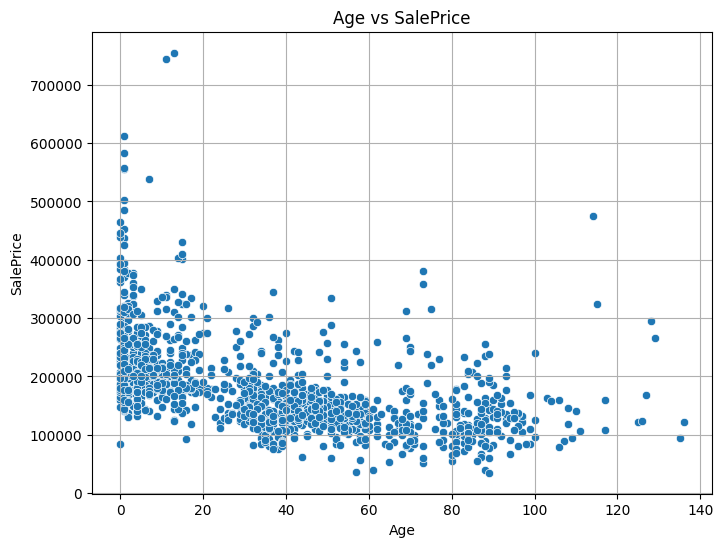

In [81]:
# 집의 연식과와 가격간의 상관관계를 시각적으로 확인
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Age', y='SalePrice', data=house_df)
plt.title('Age vs SalePrice')
plt.xlabel('Age')
plt.ylabel('SalePrice')
plt.grid(True)
plt.show()

# 연식에 따른 점수 매기기(min-max 스케일링)
min_age = house_df['Age'].min()
max_age = house_df['Age'].max()

house_df['Age_Scaled'] = 1 - ((house_df['Age'] - min_age) / (max_age - min_age))

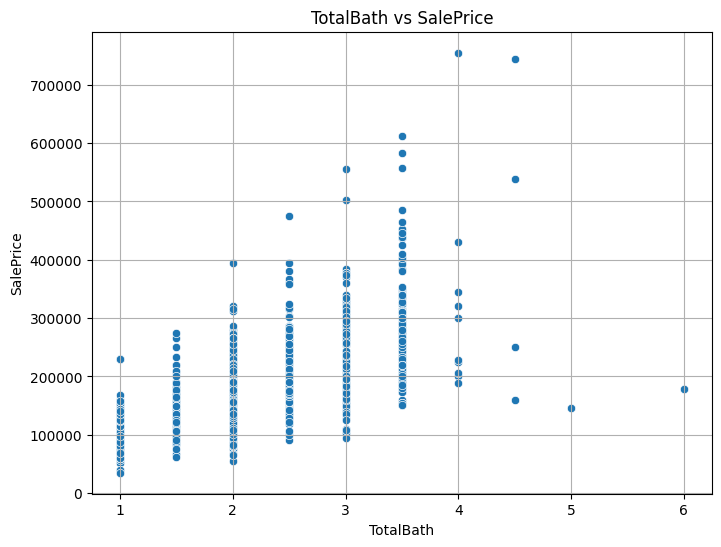

In [82]:
#욕실의 개수와 가격간의 상관관계를 시각적으로 확인
plt.figure(figsize=(8, 6))
sns.scatterplot(x='TotalBath', y='SalePrice', data=house_df)
plt.title('TotalBath vs SalePrice')
plt.xlabel('TotalBath')
plt.ylabel('SalePrice')
plt.grid(True)
plt.show()

# 욕실 개수에 따른 점수 매기기
min_age = house_df['TotalBath'].min()
max_age = house_df['TotalBath'].max()

house_df['TotalBath_Scaled'] = (house_df['TotalBath'] - min_age) / (max_age - min_age)

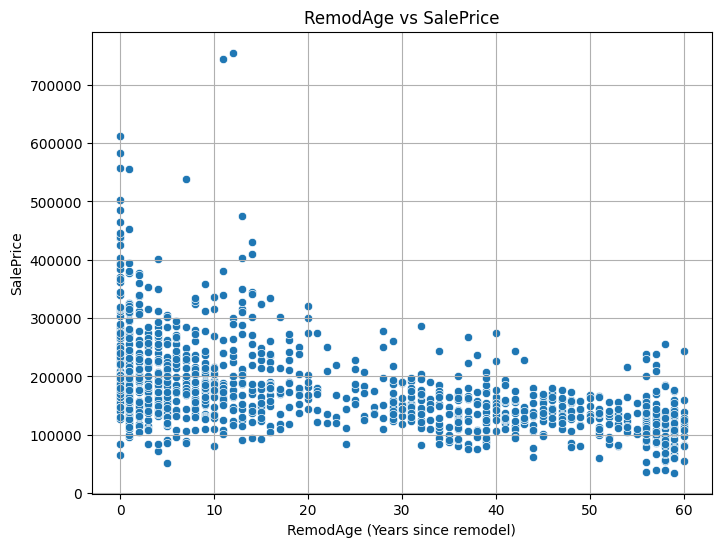

In [83]:
# 리모델링 연도와 가격간의 상관관계를 시각적으로 확인
plt.figure(figsize=(8, 6))
sns.scatterplot(x='RemodAge', y='SalePrice', data=house_df)
plt.title('RemodAge vs SalePrice')
plt.xlabel('RemodAge (Years since remodel)')
plt.ylabel('SalePrice')
plt.grid(True)
plt.show()

# 리모델링 연식에 따른 점수 매기기
min_age = house_df['RemodAge'].min()
max_age = house_df['RemodAge'].max()

house_df['RemodAge_Scaled'] = 1 - ((house_df['RemodAge'] - min_age) / (max_age - min_age))

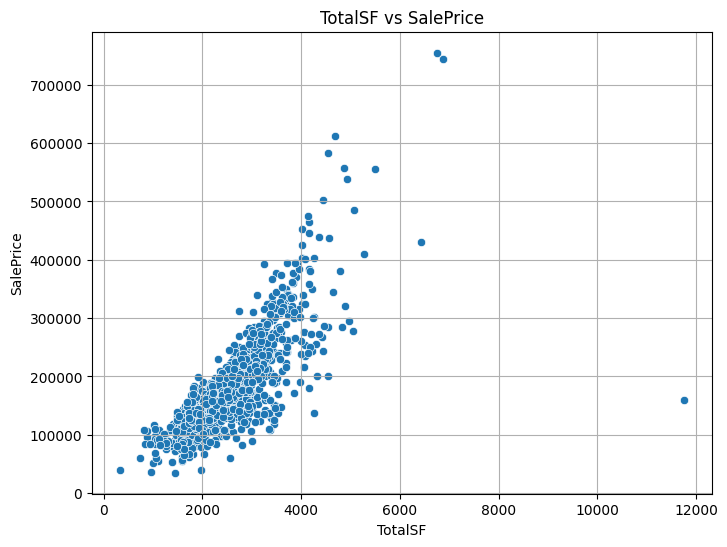

In [84]:
# 총 사용 가능한 실내 면적과 가격간의 상관관계를 시각적으로 확인
plt.figure(figsize=(8, 6))
sns.scatterplot(x='TotalSF', y='SalePrice', data=house_df)
plt.title('TotalSF vs SalePrice')
plt.xlabel('TotalSF')
plt.ylabel('SalePrice')
plt.grid(True)
plt.show()

pd.set_option('display.max_rows', 100)
house_df.iloc[64]

# 사용 가능 실내 면적에 따른 점수 매기기
min_age = house_df['TotalSF'].min()
max_age = house_df['TotalSF'].max()

house_df['TotalSF_Scaled'] = (house_df['TotalSF'] - min_age) / (max_age - min_age)

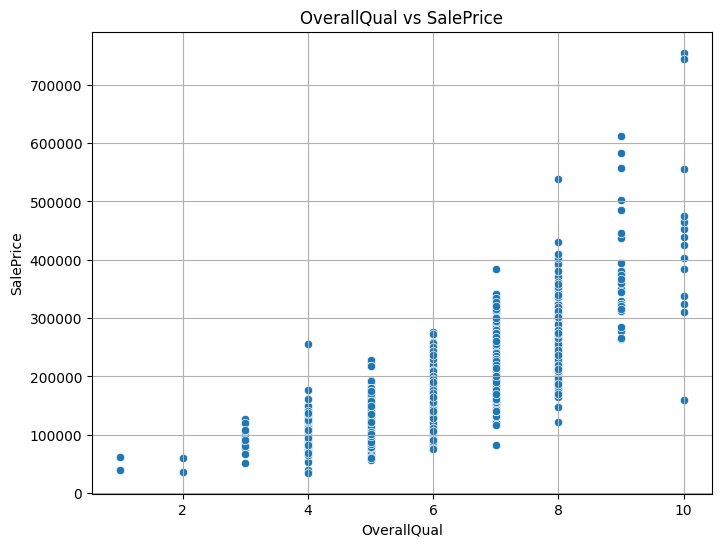

In [85]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='OverallQual', y='SalePrice', data=house_df)
plt.title('OverallQual vs SalePrice')
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')
plt.grid(True)
plt.show()

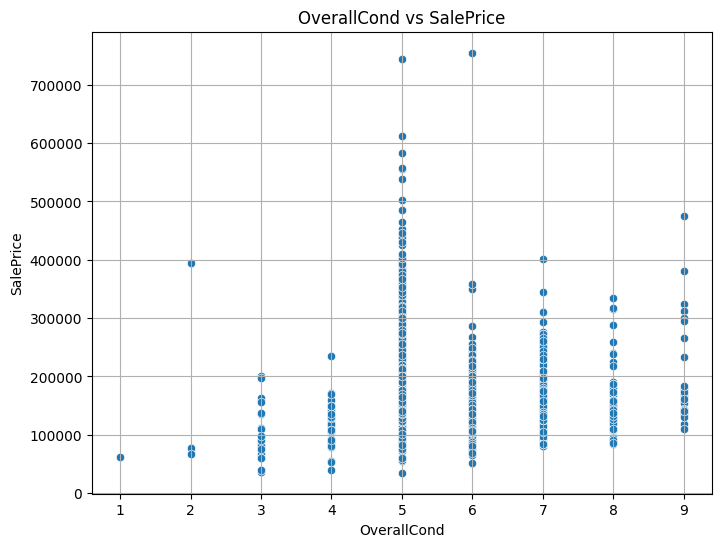

In [86]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='OverallCond', y='SalePrice', data=house_df)
plt.title('OverallCond vs SalePrice')
plt.xlabel('OverallCond')
plt.ylabel('SalePrice')
plt.grid(True)
plt.show()

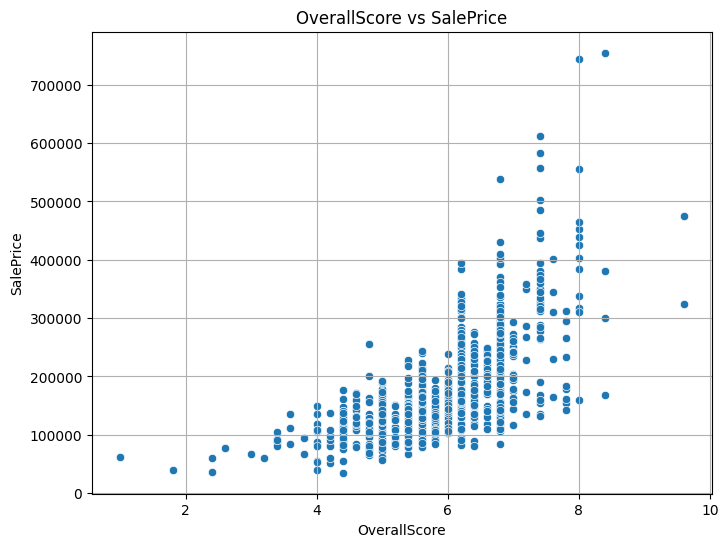

In [87]:
# 가중치를 이용해 집의 컨디션 스코어 구하기
house_df['OverallScore'] = 0.6 * house_df['OverallQual'] + 0.4 * house_df['OverallCond']

plt.figure(figsize=(8, 6))
sns.scatterplot(x='OverallScore', y='SalePrice', data=house_df)
plt.title('OverallScore vs SalePrice')
plt.xlabel('OverallScore')
plt.ylabel('SalePrice')
plt.grid(True)
plt.show()

# 집의 컨디션 스코어에 따른 점수 매기기
min_age = house_df['OverallScore'].min()
max_age = house_df['OverallScore'].max()

house_df['OverallScore_Scaled'] = (house_df['OverallScore'] - min_age) / (max_age - min_age)

점수 더해서 그래프 점수에 따른 가격의 상관관계 보기

In [88]:
house_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,RemodAge,Age,TotalBath,TotalSF,Age_Scaled,TotalBath_Scaled,RemodAge_Scaled,TotalSF_Scaled,OverallScore,OverallScore_Scaled
0,968,20,RL,NaN,7390,Pave,NaN,IR1,Lvl,AllPub,...,53,53,2.0,2196,0.610294,0.2,0.116667,0.163076,5.8,0.558140
1,739,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,...,21,22,6.0,2400,0.838235,1.0,0.650000,0.180942,5.0,0.465116
2,696,20,RL,54.0,13811,Pave,NaN,IR1,Lvl,AllPub,...,19,19,3.0,2249,0.860294,0.4,0.683333,0.167718,6.0,0.581395
3,239,20,RL,93.0,12030,Pave,NaN,Reg,Lvl,AllPub,...,0,0,2.0,3388,1.000000,0.2,1.000000,0.267472,6.8,0.674419
4,891,50,RL,60.0,8064,Pave,NaN,Reg,Lvl,AllPub,...,1,58,1.0,1596,0.573529,0.0,0.983333,0.110527,5.8,0.558140


In [89]:
house_df['total_score'] = house_df['Age_Scaled'] + house_df['TotalBath_Scaled'] + house_df['RemodAge_Scaled'] + house_df['TotalSF_Scaled'] + house_df['OverallScore_Scaled']

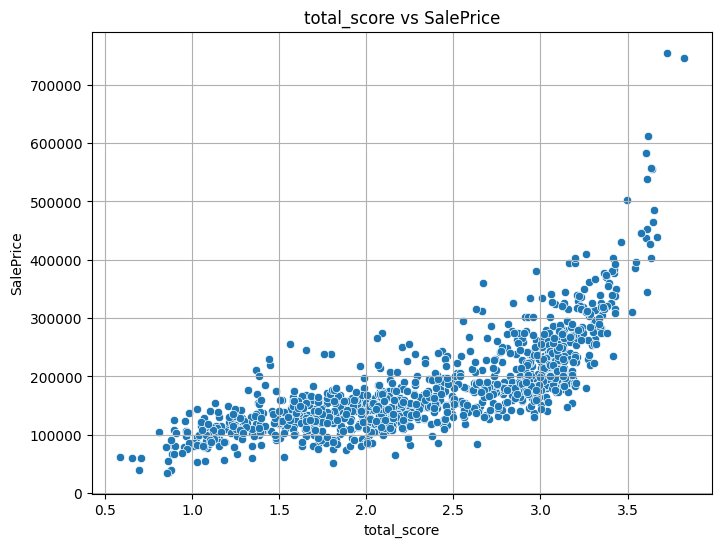

In [90]:

#이상치 제거
house_df = house_df[~((house_df['total_score'] > 4.5) & (house_df['SalePrice'] < 200000))]

house_df = house_df[~((house_df['total_score'] > 2) & (house_df['total_score'] < 3) & (house_df['SalePrice'] > 400000))]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='total_score', y='SalePrice', data=house_df)
plt.title('total_score vs SalePrice')
plt.xlabel('total_score')
plt.ylabel('SalePrice')
plt.grid(True)
plt.show()

In [91]:
# 불필요한 컬럼 삭제
house_df.drop(['Age_Scaled','TotalBath_Scaled','RemodAge_Scaled','TotalSF_Scaled','OverallScore_Scaled'], axis=1 , inplace=True)
house_df.drop(['YrSold','YearRemodAdd','YearBuilt','FullBath','HalfBath','BsmtFullBath','BsmtHalfBath','TotalBsmtSF','1stFlrSF','2ndFlrSF'], axis=1 , inplace=True)

### 1-3. target값(SalePrice) 확인
- 정규 분포인지 확인
- 정규 분포가 아니라면 log 변환하여 정규분포로 변경
- log 변환 값을 데이터 프레임에 적용

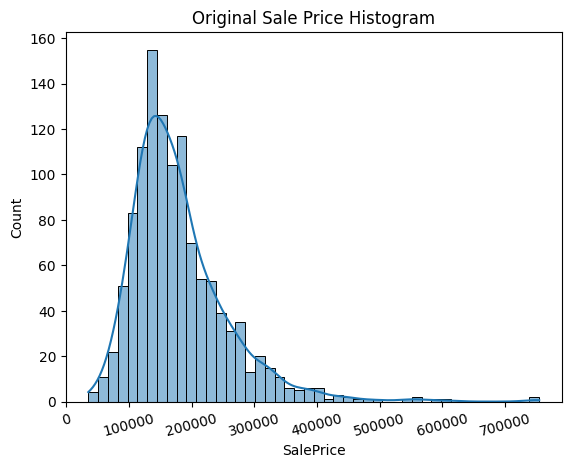

In [92]:
#log 변환 적용 전 타켓값의 분포
plt.title('Original Sale Price Histogram')
plt.xticks(rotation=15)
sns.histplot(house_df['SalePrice'], kde=True)
plt.show()

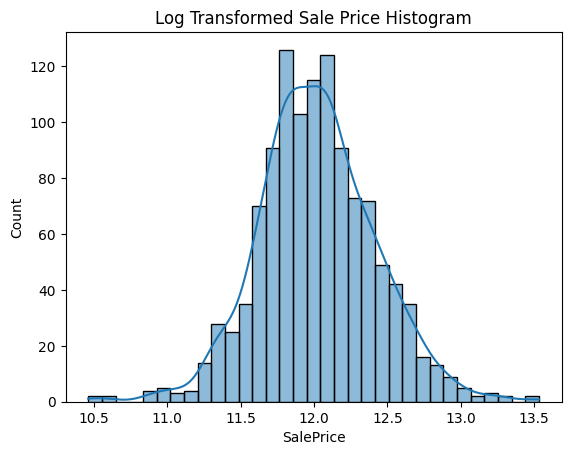

In [93]:
#log 변환 적용 후 타켓값의 분포
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.histplot(log_SalePrice, kde=True)
plt.show()

In [94]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

### 1-4. null값과 불필요한 컬럼 처리
- null 값 처리
  - null값이 이 넘으면 해당 컬럼은 삭제
  - 나머지 숫자형 null 컬럼들은 평균값으로 대체

- 불필요한 컬럼 삭제


In [95]:
#불필요한 컬럼 삭제
house_df.drop(['Id'], axis=1 , inplace=True)

# Drop 하지 않는 숫자형 Null컬럼들은 평균값으로 대체
num_cols = house_df.select_dtypes(include=['number']).columns
house_df[num_cols] = house_df[num_cols].fillna(house_df[num_cols].mean())

#Null 이 너무 많은 컬럼들 삭제
house_df.drop(['PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu','MasVnrType'], axis=1 , inplace=True)

### 1-5. 원-핫 인코딩


In [96]:
# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type :
 BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [97]:
house_df.shape

(1165, 70)

In [98]:
isnull_series = house_df.isnull().sum()
print('\nNull 컬럼과 그 건수:\n ', isnull_series[isnull_series > 0].sort_values(ascending=False))


Null 컬럼과 그 건수:
  GarageQual      69
GarageCond      69
GarageFinish    69
GarageType      69
BsmtFinType2    24
BsmtExposure    24
BsmtCond        23
BsmtQual        23
BsmtFinType1    23
Electrical       1
dtype: int64


In [99]:
print('get_dummies() 수행 전 데이터 Shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 Shape: (1165, 70)
get_dummies() 수행 후 데이터 Shape: (1165, 258)
## Null 피처의 Type :
 Series([], dtype: object)


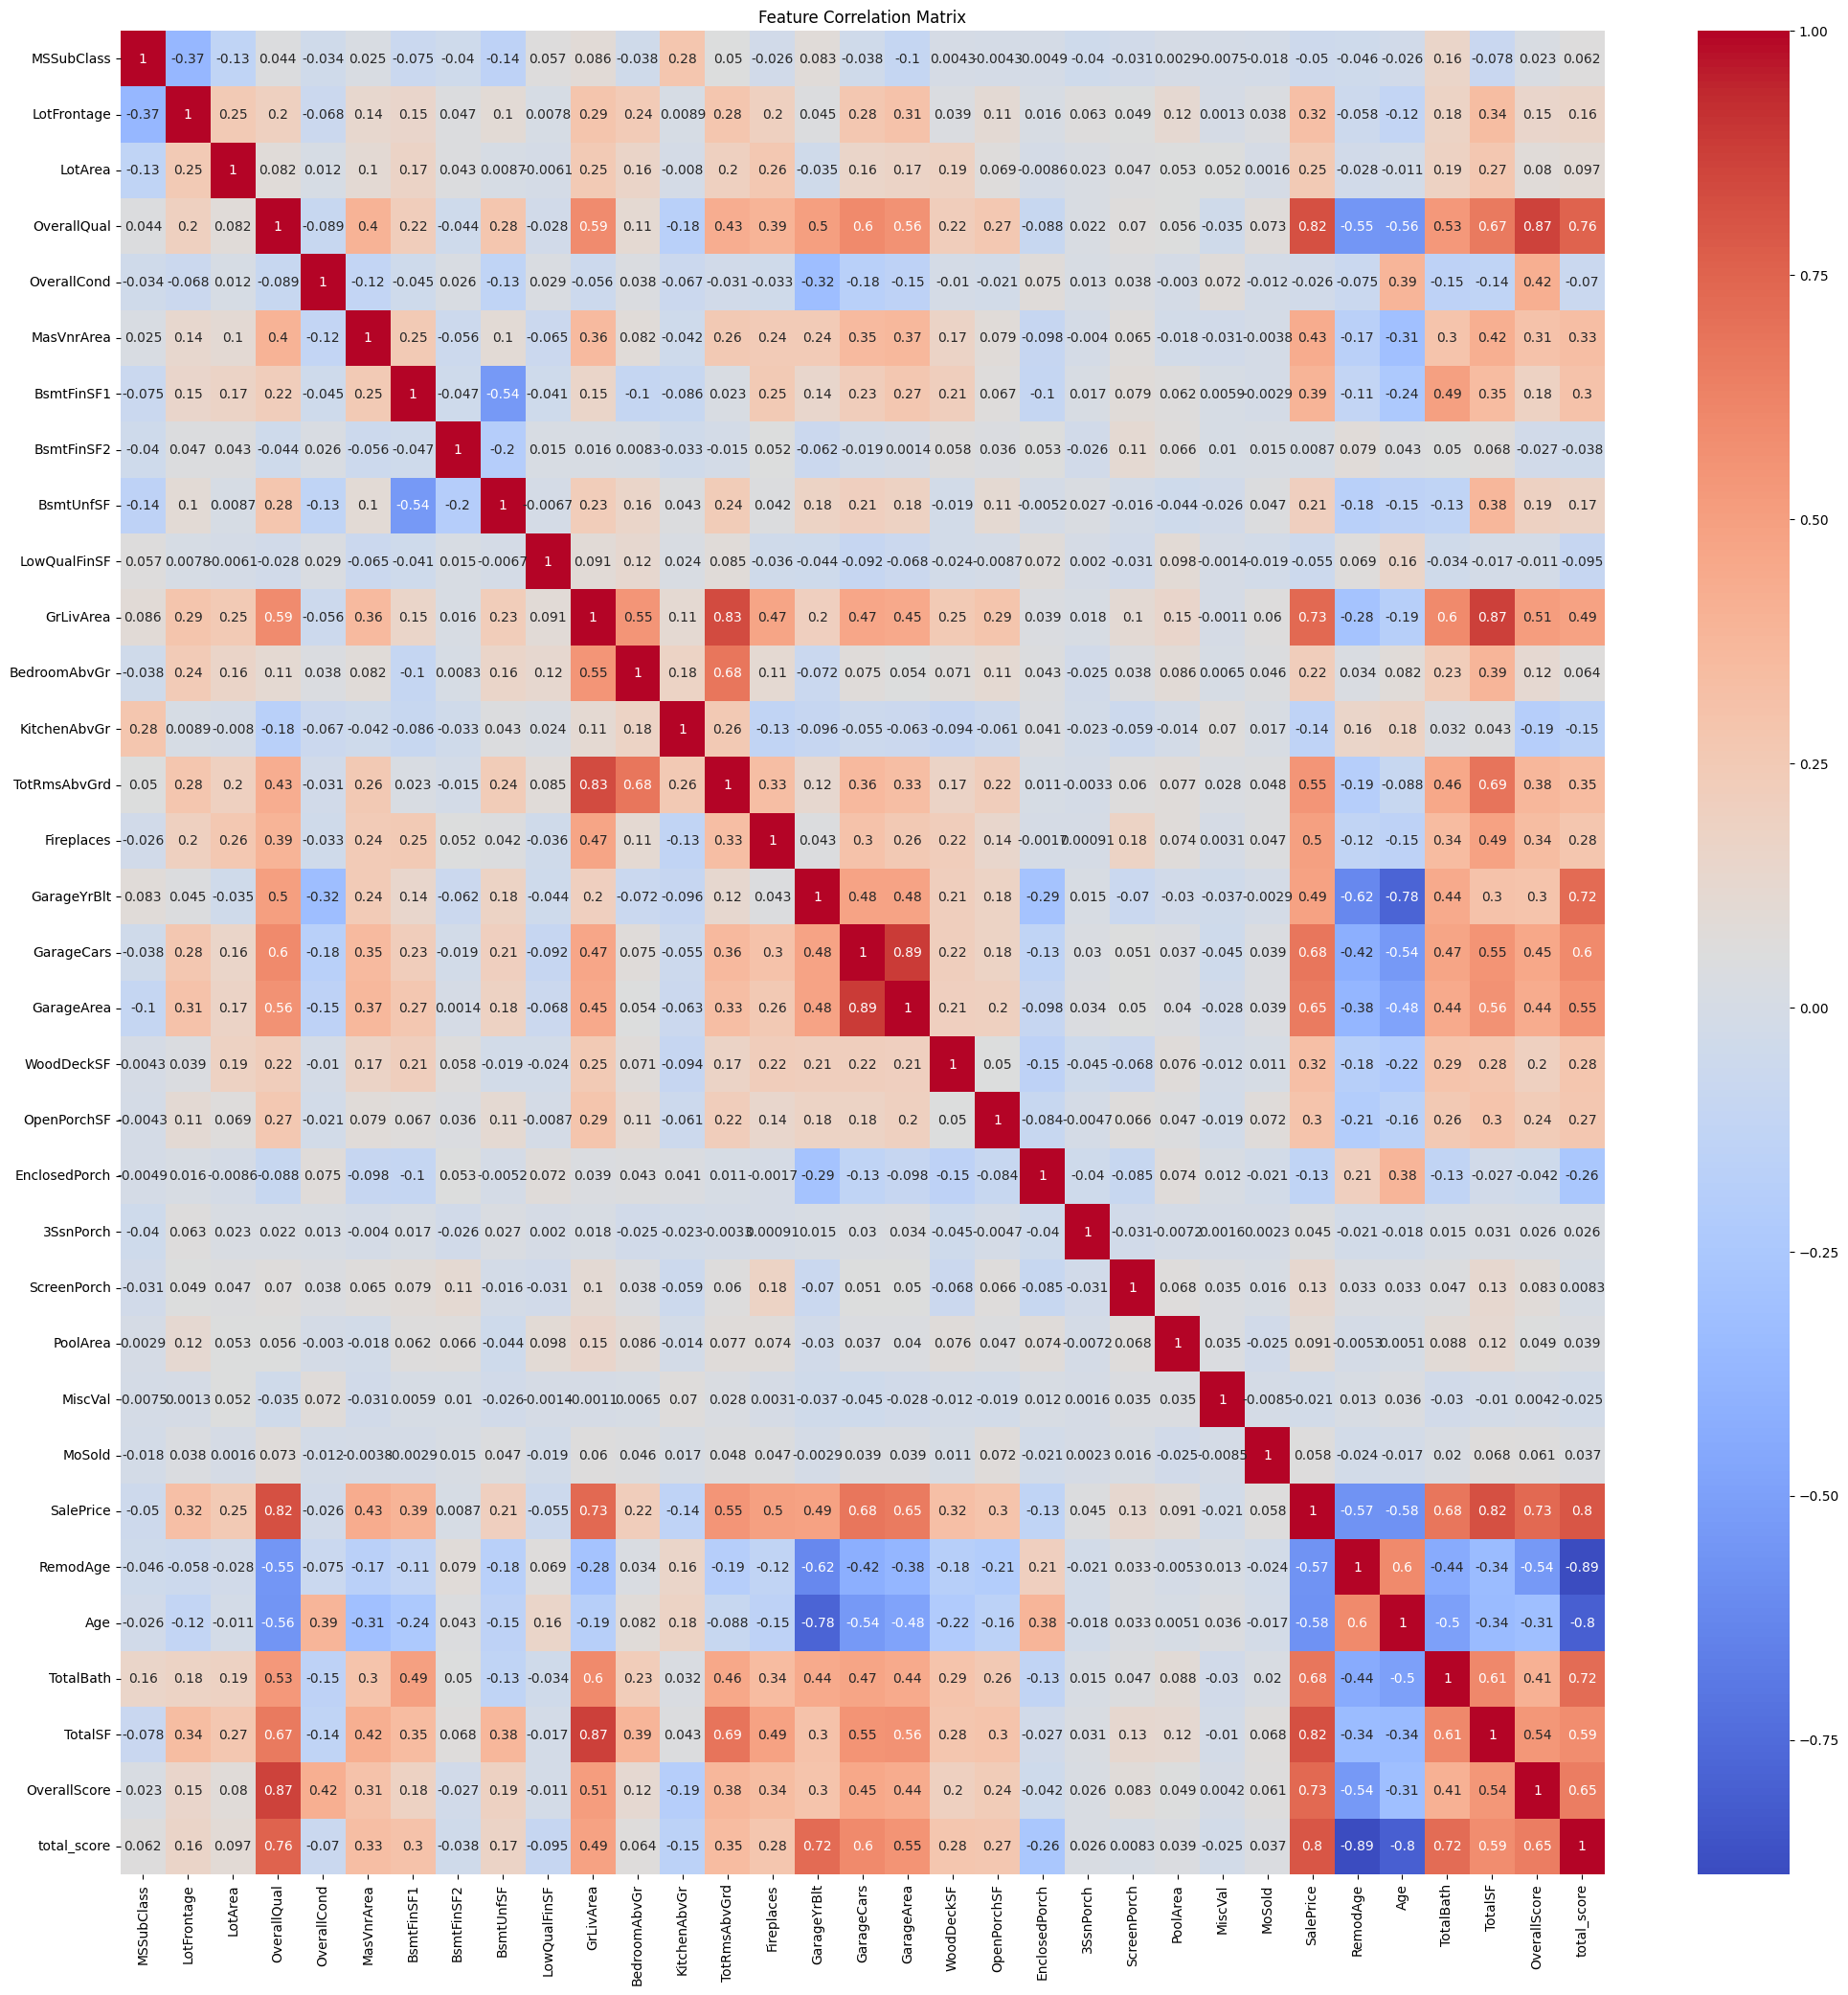

In [100]:
# 상관계수 - 히트맵
correlation_matrix = house_df.select_dtypes(include=['number']).corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 25))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

- VIF(분산팽창계수) 계산하여 다중공선성 여부를 정량적으로 확인

In [101]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = house_df[['TotRmsAbvGrd', 'GrLivArea']]
X = add_constant(X)  # 상수항 추가
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

       Variable        VIF
0         const  17.585775
1  TotRmsAbvGrd   3.250007
2     GrLivArea   3.250007


In [102]:
# X = house_df[['GarageYrBlt', 'YearBuilt']]
# X = add_constant(X)  # 상수항 추가
# vif = pd.DataFrame()
# vif["Variable"] = X.columns
# vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
# print(vif)

In [103]:
# X = house_df[['SalePrice', 'OverallQual']]
# X = add_constant(X)  # 상수항 추가
# vif = pd.DataFrame()
# vif["Variable"] = X.columns
# vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
# print(vif)

In [104]:
# X = house_df[['TotalBsmtSF', '1stFlrSF']]
# X = add_constant(X)  # 상수항 추가
# vif = pd.DataFrame()
# vif["Variable"] = X.columns
# vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
# print(vif)

#3. 선형 회귀 모델 학습/예측/평가

In [105]:
def get_rmse(model):
    pred = model.predict(X_test)
    pred_exp = np.expm1(pred)
    mse = mean_squared_error(np.expm1(y_test) , pred_exp)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    print('{0} 로그 변환된 MSE: {1}'.format(model.__class__.__name__,np.round(mse, 3)))
    return rmse

def get_rmses(models):
    rmses = [ ]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [106]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 18835.373
LinearRegression 로그 변환된 MSE: 354771293.772
Ridge 로그 변환된 RMSE: 18346.585
Ridge 로그 변환된 MSE: 336597177.09
Lasso 로그 변환된 RMSE: 27760.788
Lasso 로그 변환된 MSE: 770661337.144


[np.float64(18835.37347046018),
 np.float64(18346.58488901715),
 np.float64(27760.787761581498)]

In [107]:
def get_top_bottom_coef(model):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명.
    coef = pd.Series(model.coef_, index=X_features.columns)

    # + 상위 10개 , - 하위 10개 coefficient 추출하여 반환.
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low

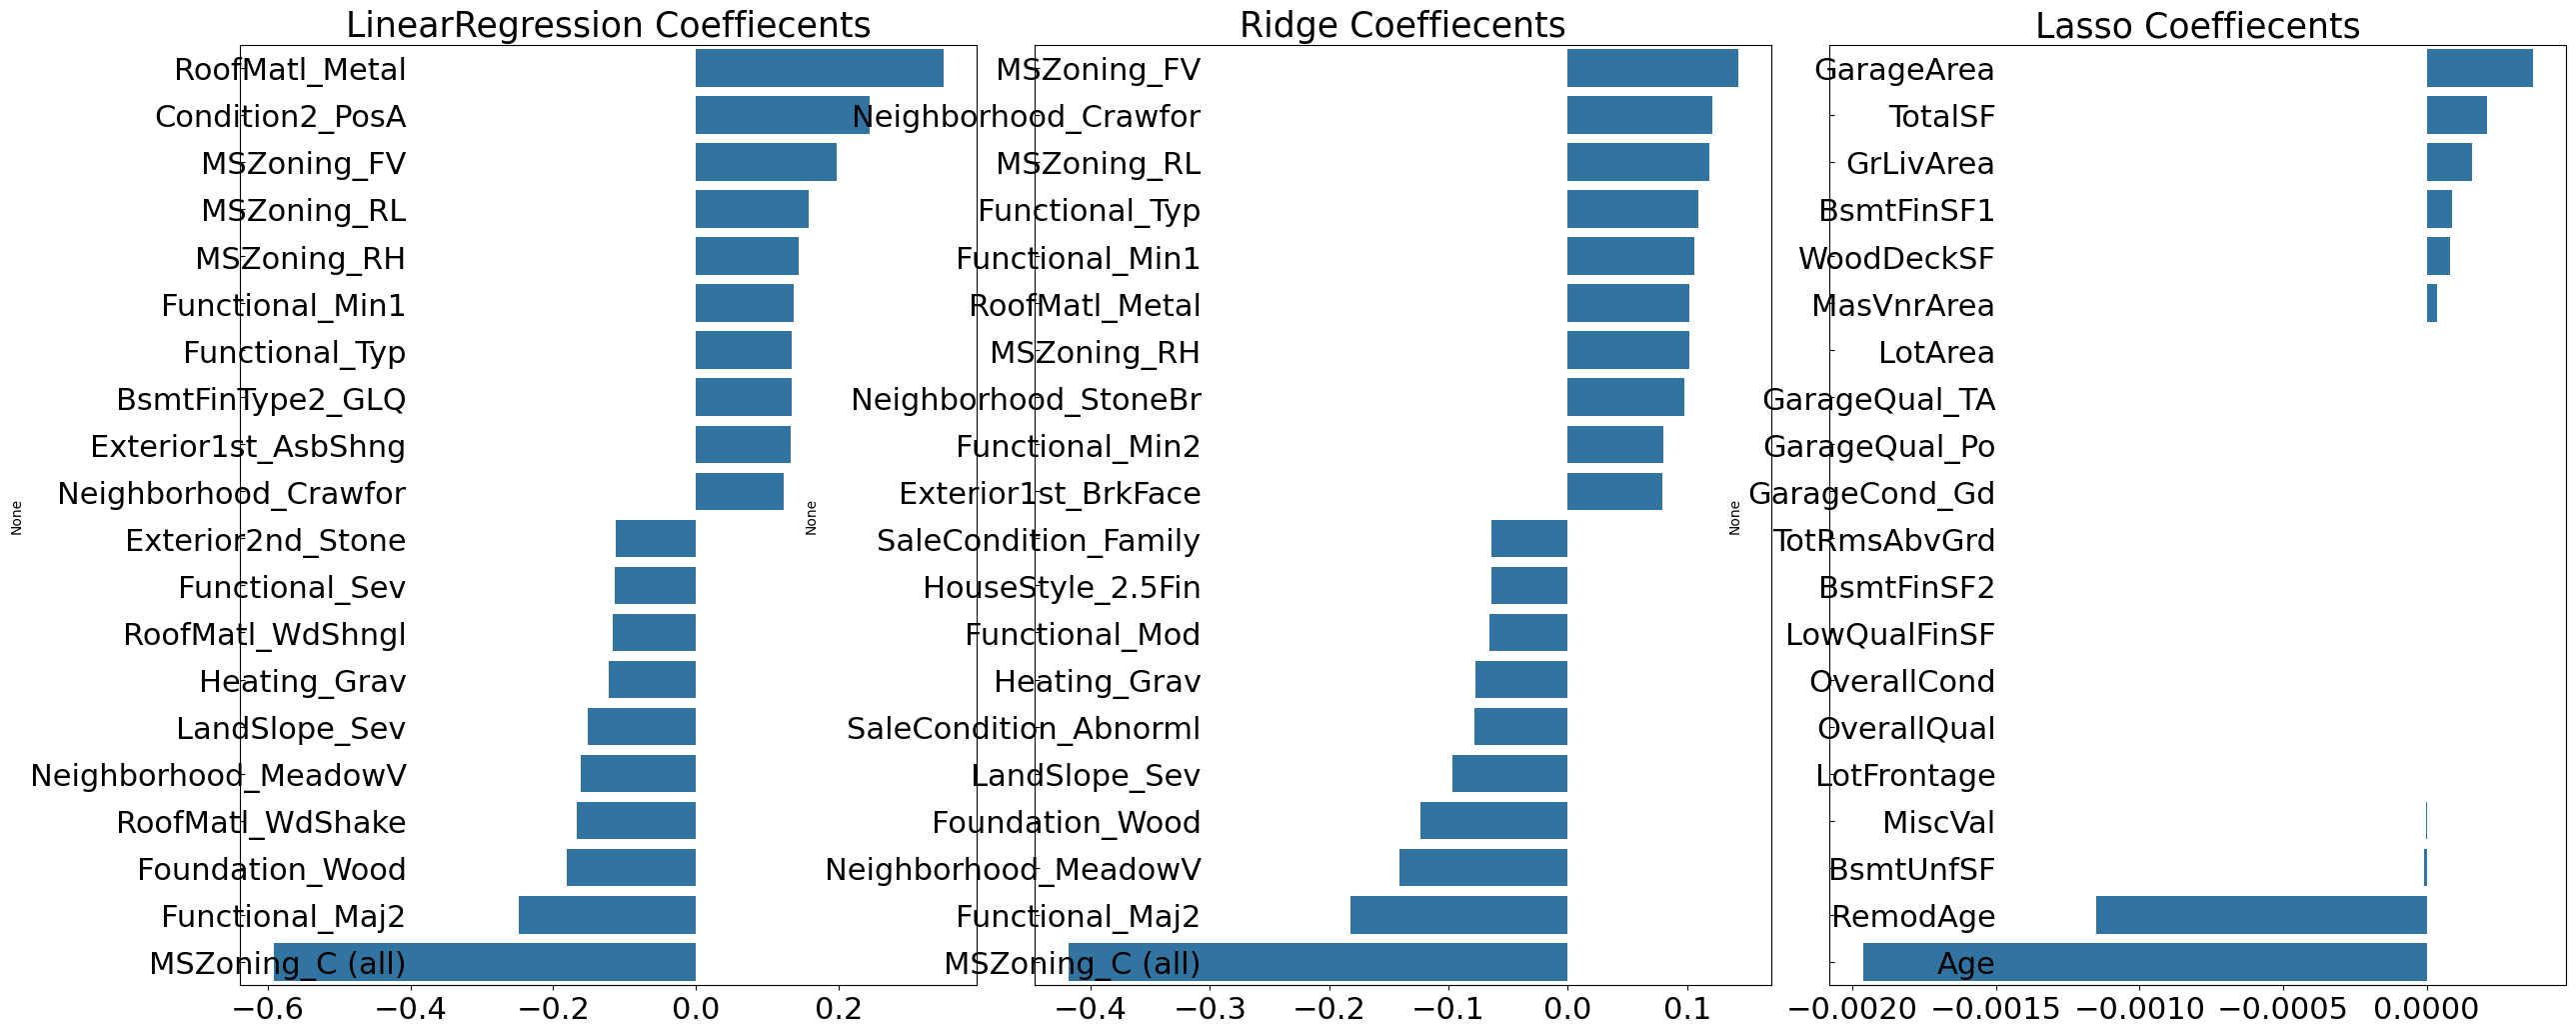

In [108]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout()
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화.
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합.
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정.
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화.
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [109]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score( ) 수행. 모델별 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                             scoring="neg_mean_squared_error", cv = 5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format( model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format( model.__class__.__name__, np.round(rmse_avg, 3)))

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE값 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [0.127 0.152 0.109 0.125 0.108]
LinearRegression CV 평균 RMSE 값: 0.124

Ridge CV RMSE 값 리스트: [0.124 0.142 0.104 0.122 0.106]
Ridge CV 평균 RMSE 값: 0.12

Lasso CV RMSE 값 리스트: [0.178 0.18  0.165 0.178 0.171]
Lasso CV 평균 RMSE 값: 0.174


In [110]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_rige = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1183, 최적 alpha:{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1159, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 18835.373
LinearRegression 로그 변환된 MSE: 354771293.772
Ridge 로그 변환된 RMSE: 17399.354
Ridge 로그 변환된 MSE: 302737529.297
Lasso 로그 변환된 RMSE: 16658.404
Lasso 로그 변환된 MSE: 277502430.019


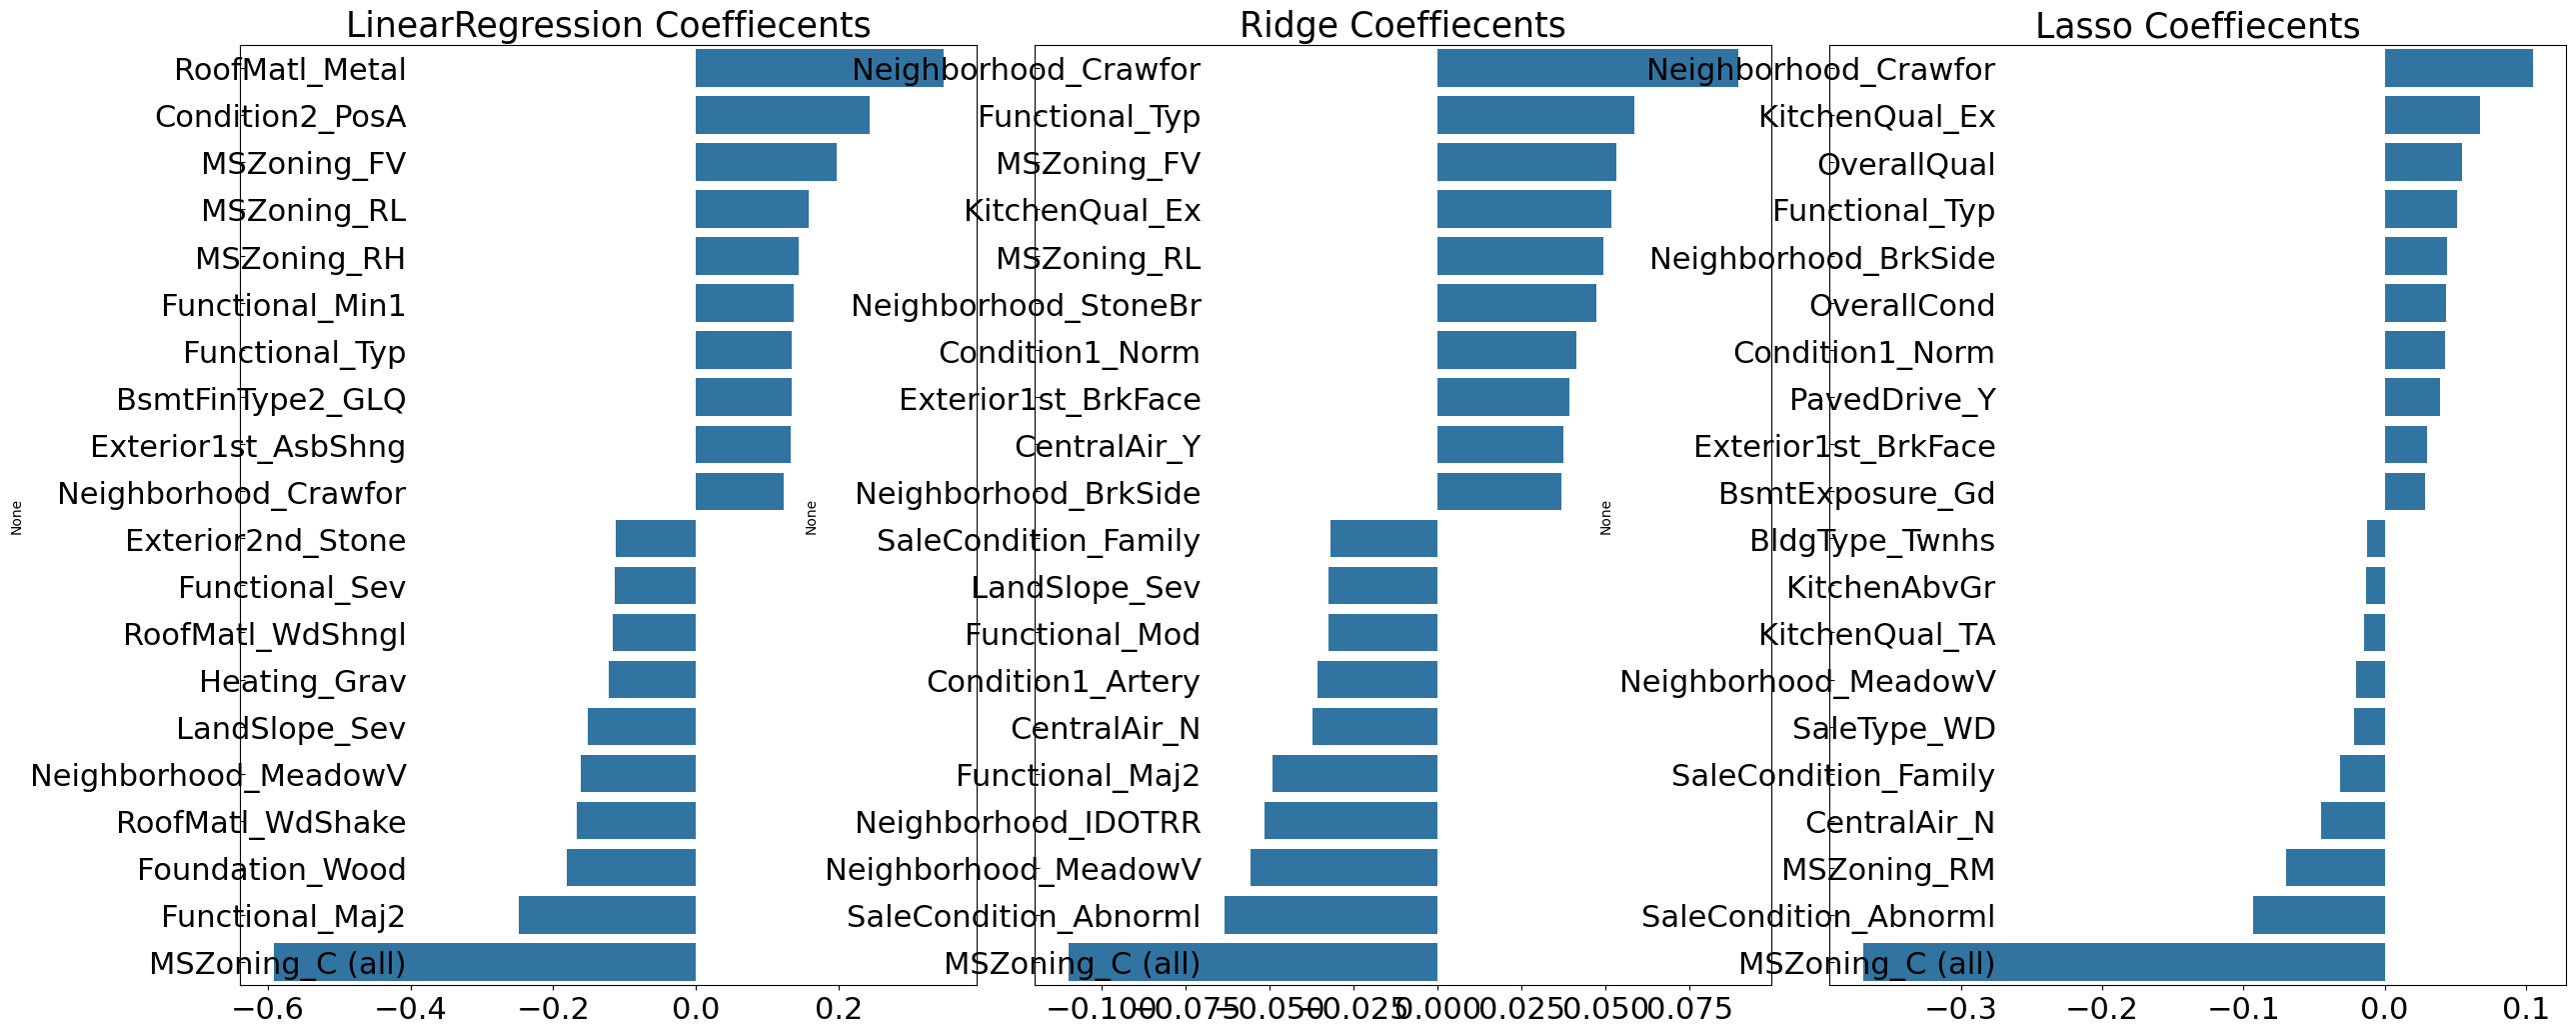

In [111]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행.
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [112]:
from scipy.stats import skew

# object가 아닌 숫자형 피처의 칼럼 index 객체 추출.
features_index = house_df.dtypes[house_df.dtypes != 'object'].index
# house_df에 칼럼 index를 [ ]로 입력하면 해당하는 칼럼 데이터 세트 반환. apply lambda로 skew( ) 호출
skew_features = house_df[features_index].apply(lambda x : skew(x))
# skew(왜곡) 정도가 1 이상인 칼럼만 추출.
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          22.070656
PoolArea         15.666888
LotArea          11.631794
3SsnPorch        11.026128
LowQualFinSF      9.849530
BsmtFinSF2        4.500667
KitchenAbvGr      4.481724
ScreenPorch       3.956789
EnclosedPorch     3.088831
OpenPorchSF       2.447518
MasVnrArea        2.428887
LotFrontage       1.993496
WoodDeckSF        1.551274
MSSubClass        1.391557
GrLivArea         1.035930
dtype: float64


In [113]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [114]:
# Skew가 높은 피처들을 로그 변환 했으므로 다시 원-핫 인코딩 적용 및 피처/타겟 데이터 셋 생성,
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 피처들을 로그 변환 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1135, 최적 alpha:{'alpha': 5}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1118, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 17988.7
LinearRegression 로그 변환된 MSE: 323593345.238
Ridge 로그 변환된 RMSE: 16985.997
Ridge 로그 변환된 MSE: 288524091.972
Lasso 로그 변환된 RMSE: 16247.827
Lasso 로그 변환된 MSE: 263991873.625


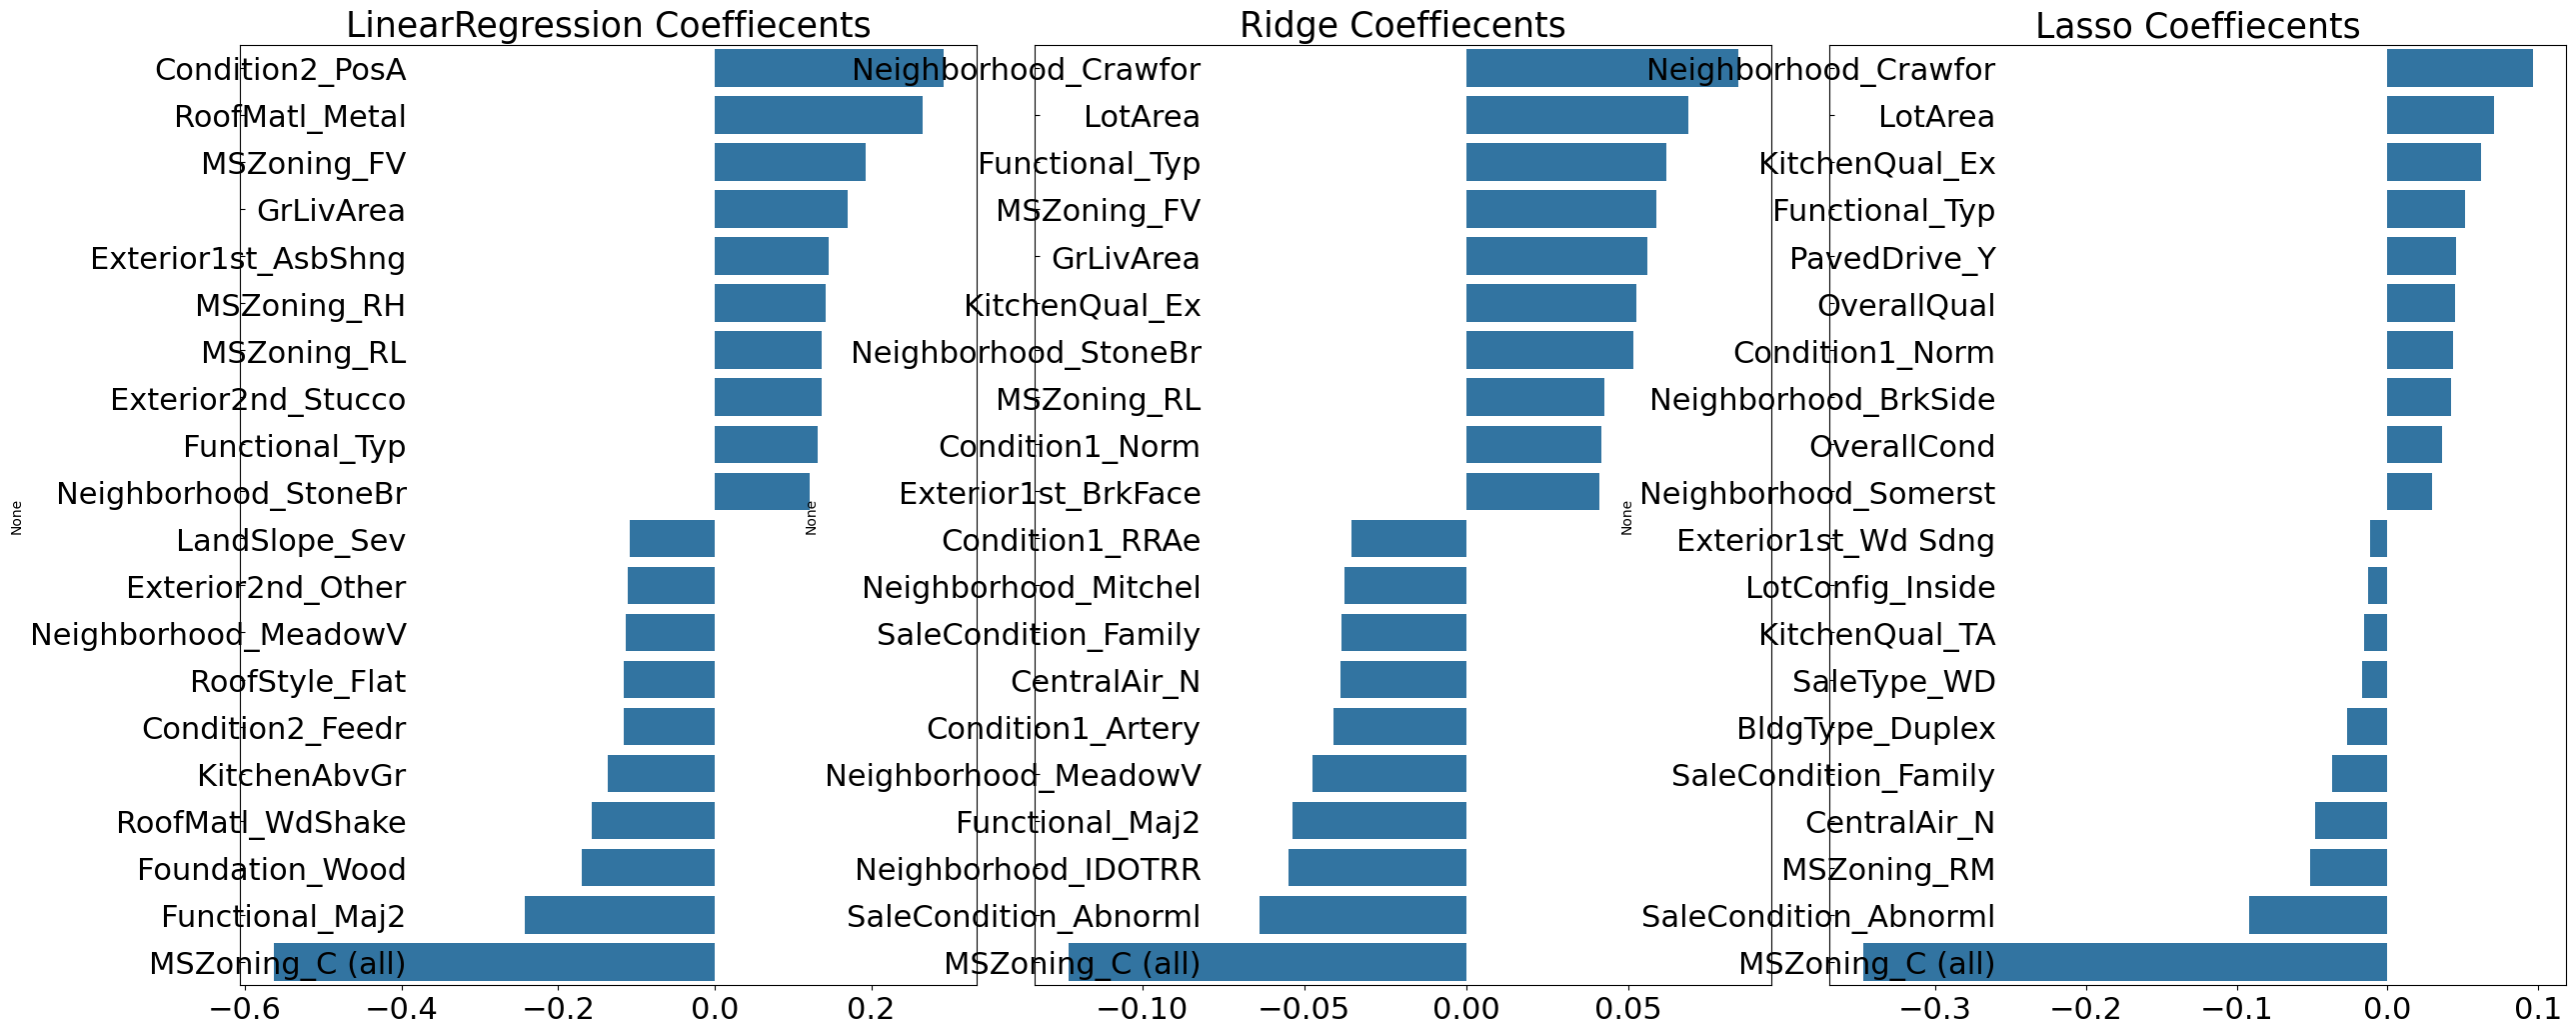

In [115]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행.
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

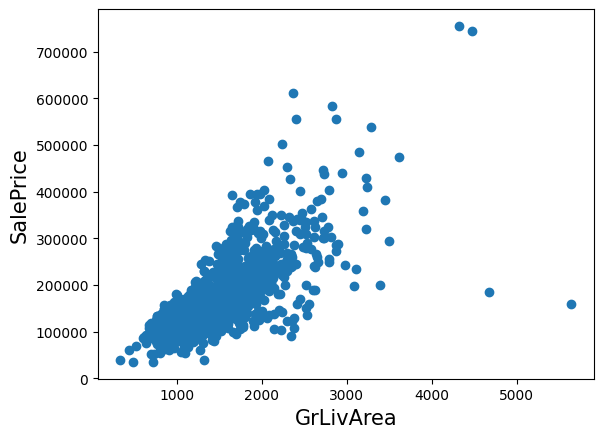

In [116]:
plt.scatter(x = house_df_org['GrLivArea'], y = house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

In [117]:
# GrLivArea와 SalePrice 모두 로그 변환되었으므로 이를 반영한 조건 생성.
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('아웃라이어 레코드 index :', outlier_index.values)
print('아웃라이어 삭제 전 house_df_ohe shape:', house_df_ohe.shape)
# DataFrame의 index를 이용하여 아웃라이어 레코드 삭제.
house_df_ohe.drop(outlier_index , axis=0, inplace=True)
print('아웃라이어 삭제 후 house_df_ohe shape:', house_df_ohe.shape)

아웃라이어 레코드 index : []
아웃라이어 삭제 전 house_df_ohe shape: (1165, 258)
아웃라이어 삭제 후 house_df_ohe shape: (1165, 258)


In [118]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1135, 최적 alpha:{'alpha': 5}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1118, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 17988.7
LinearRegression 로그 변환된 MSE: 323593345.238
Ridge 로그 변환된 RMSE: 17047.16
Ridge 로그 변환된 MSE: 290605662.742
Lasso 로그 변환된 RMSE: 16247.827
Lasso 로그 변환된 MSE: 263991873.625


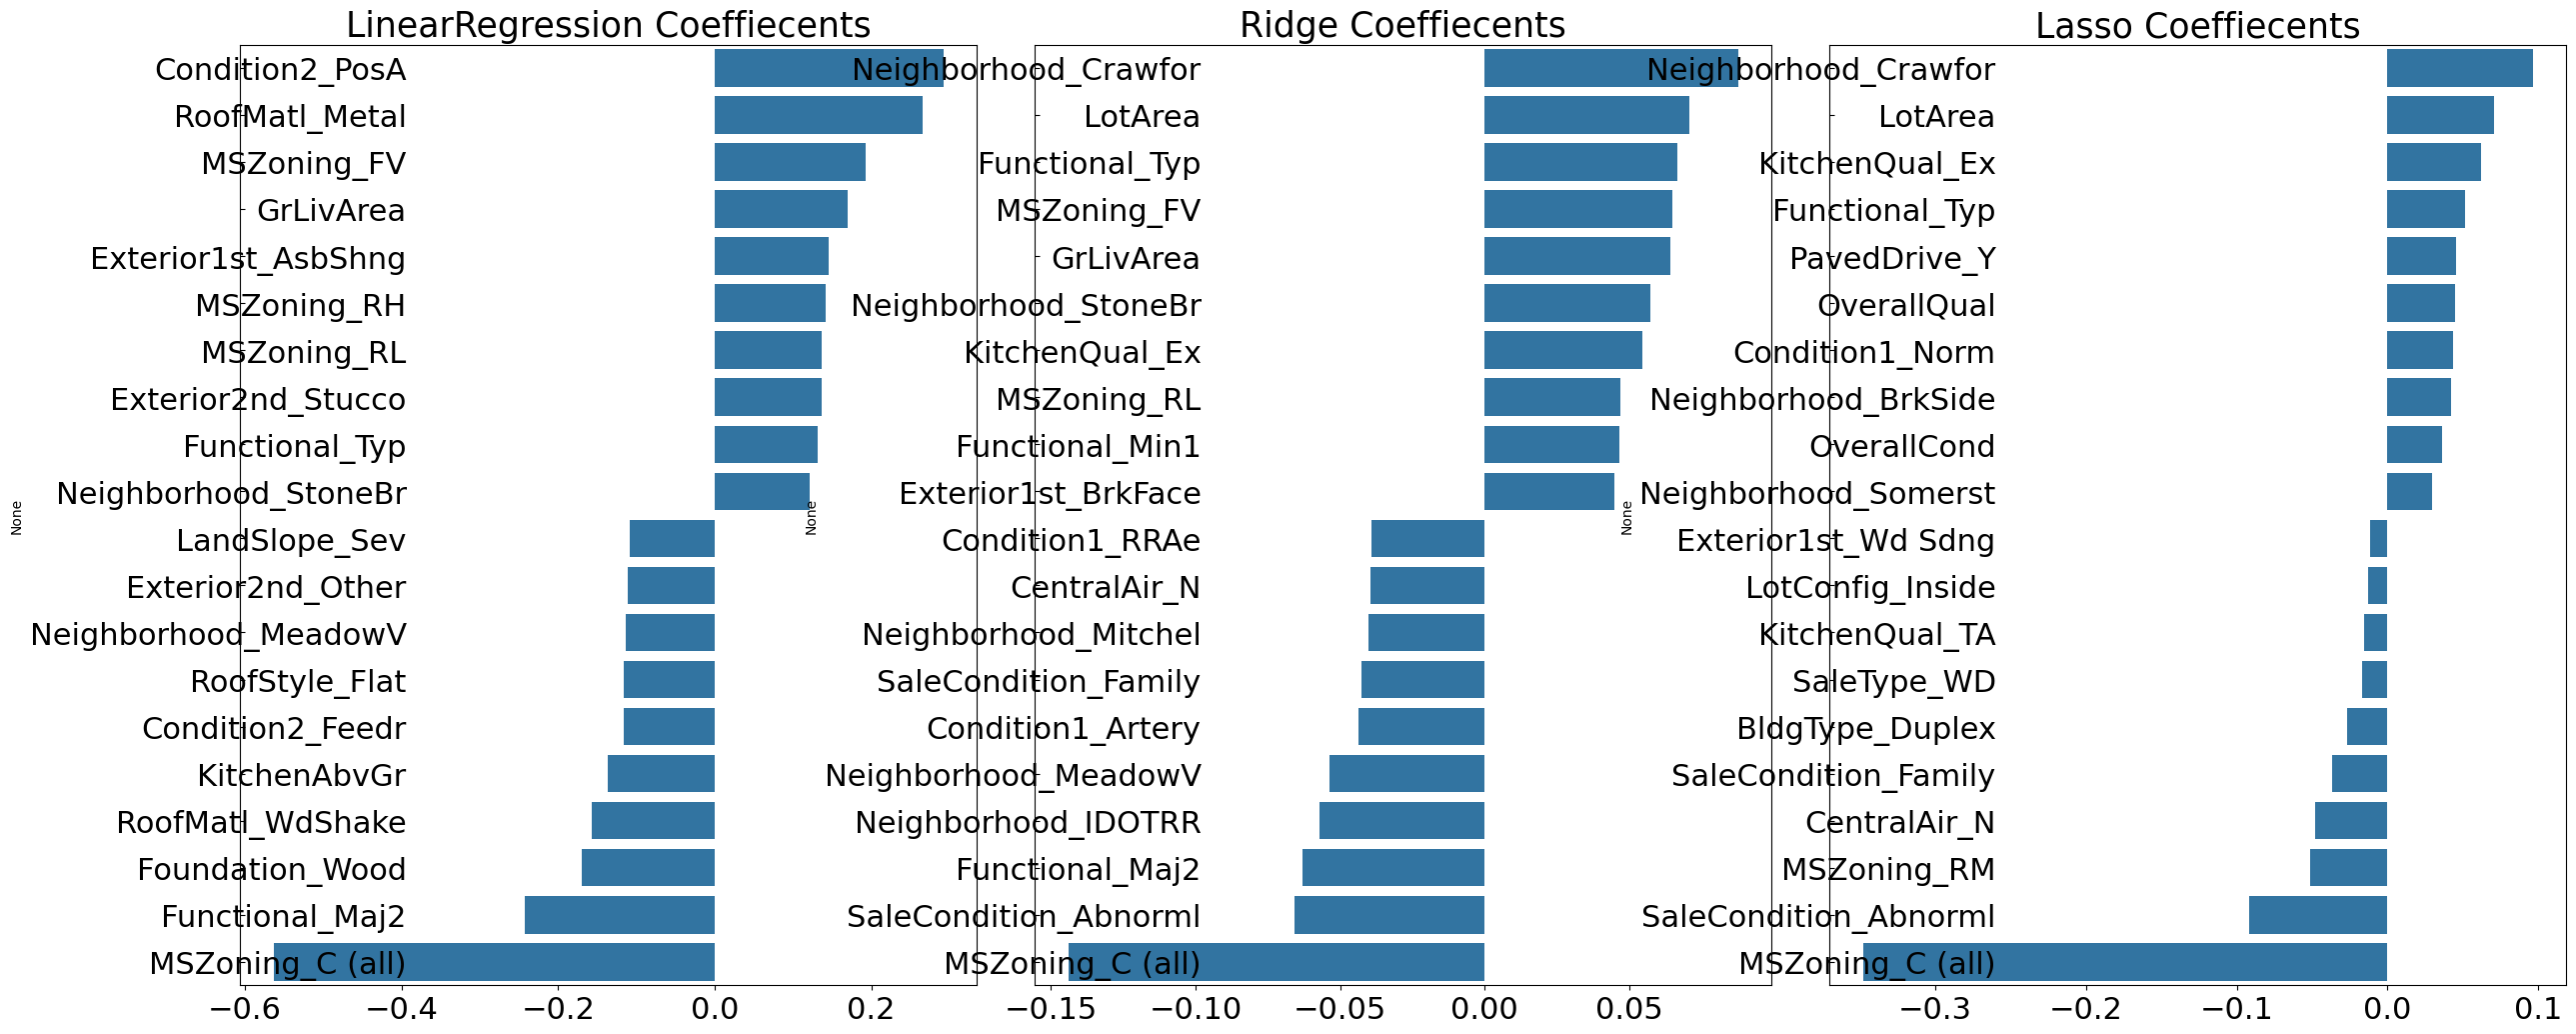

In [119]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행.
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [120]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05,
                       colsample_bytree=0.5, subsample=0.8)
best_xgb = print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.1206, 최적 alpha:{'n_estimators': 1000}


In [121]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4,
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
best_lgbm = print_best_params(lgbm_reg, lgbm_params)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2825
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 158
[LightGBM] [Info] Start training from score 12.019448
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2808
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 150
[LightGBM] [Info] Start training from score 12.024548
[LightGBM] [Warning] Found w

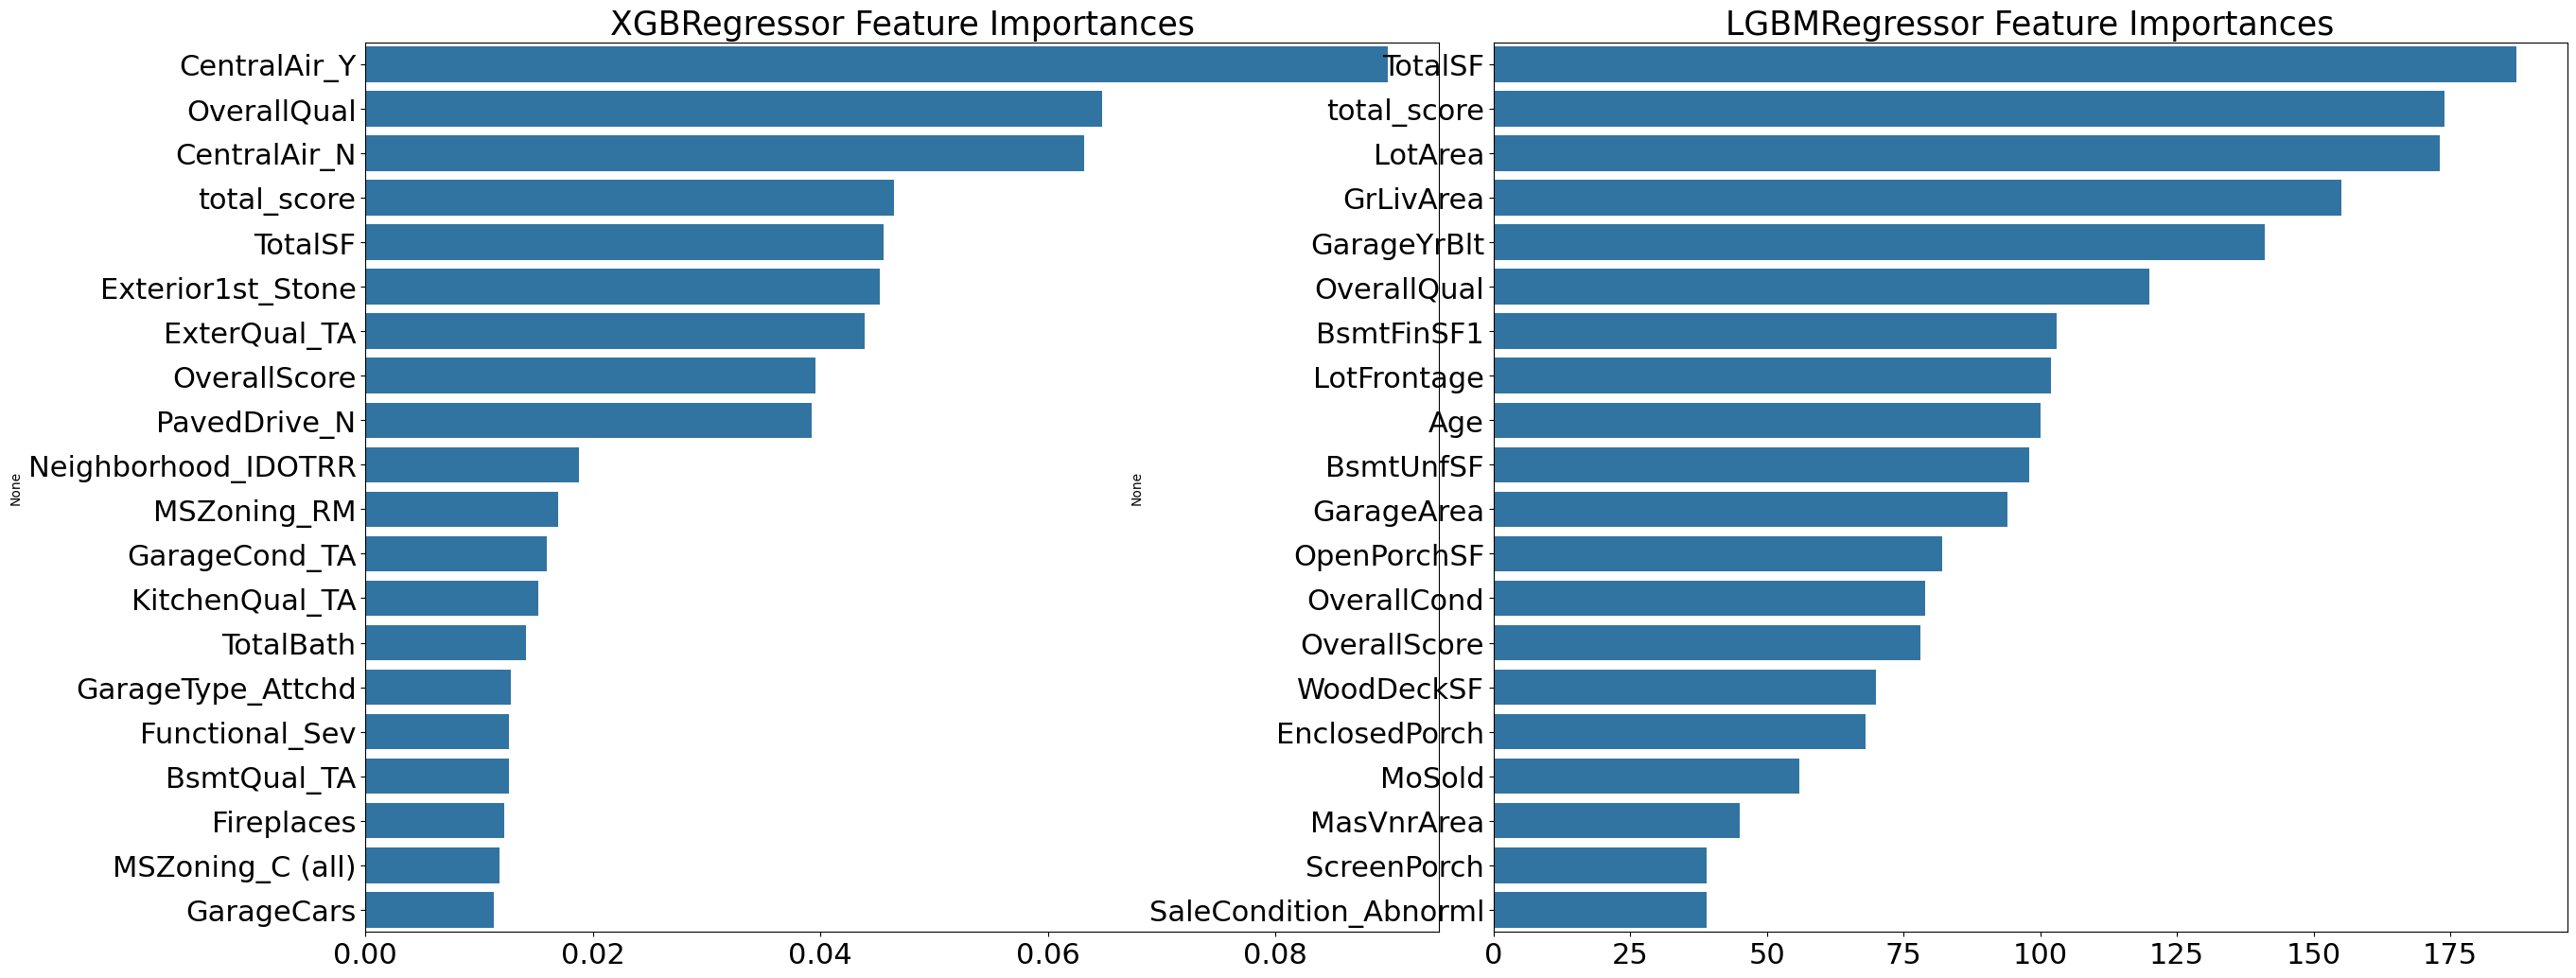

In [122]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_features.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout()
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화.
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

# 앞 예제에서 print_best_params( )가 반환한 GridSearchCV로 최적화된 모델의 피처 중요도 시각화
models = [best_xgb, best_lgbm]
visualize_ftr_importances(models)

In [123]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test , pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))

# 개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}
#최종 혼합 모델, 개별모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.10126672969051448
Ridge 모델의 RMSE: 0.10634948401376014
Lasso 모델의 RMSE: 0.10034347926955954


In [124]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05,
                       colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4,
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}

get_rmse_pred(preds)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 148
[LightGBM] [Info] Start training from score 12.025591
최종 혼합 모델의 RMSE: 0.10448927047559356
XGBM 모델의 RMSE: 0.1091174813034703
LGBM 모델의 RMSE: 0.10666840538160705


In [125]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수.
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')

    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장.
        test_pred[:, folder_counter] = model.predict(X_test_n)

    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [126]:
# get_stacking_base_datasets( )은 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환.
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환.
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2601
[LightGBM] [Info] Number of data points in the train set: 745, number of used features: 139
[LightGBM] [Info] Start training from score 12.035266
	 폴드 세트:  1  시작 
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=tru

In [127]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 Stacking 형태로 결합.
Stack_final_X_train = np.concatenate((ridge_train, lasso_train,
                                      xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test,
                                     xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용.
meta_model_lasso = Lasso(alpha=0.0005)

#기반 모델의 예측값을 기반으로 새롭게 만들어진 학습 및 테스트용 데이터로 예측하고 RMSE 측정.
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test , final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

스태킹 회귀 모델의 최종 RMSE 값은: 0.10052978119494775


# 제출용 Test 데이터 전처리 진행

### train에 진행된 전처리
- NUll 많은 컬럼 삭제
- skew 컬럼 로그 변환
- 원핫 인코딩

결과값의 컬럼 개수가 266개여야한다

또 test와 train의 원핫인코딩 이후 개수가 달라지는 현상이 발생하게되는데

이때는 값이 너무 많아서
```
test_ohe1 = pd.get_dummies(test)
test_ohe2 = test_ohe1.reindex(columns=X_train.columns, fill_value=0)
```
이런 방식으로 train과 열 개수를 맞춰주는 방식을 사용해봄
- 다른 방식을 사용해보셔도 좋습니다~

In [128]:
X_train.shape

(932, 257)

In [129]:
## test_data를 받아오기
test = pd.read_csv('./test.csv')

# total score 만들기
test['RemodAge'] = test['YrSold'] - test['YearRemodAdd']
test['Age'] = test['YrSold'] - test['YearBuilt']
test['TotalBath'] = test['FullBath'] + test['HalfBath']*0.5 + test['BsmtFullBath'] + test['BsmtHalfBath']*0.5
test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']
test = test[~(test['RemodAge'] < 0)]


# 연식에 따른 점수 매기기(min-max 스케일링)
min_age = test['Age'].min()
max_age = test['Age'].max()

test['Age_Scaled'] = 1 - ((test['Age'] - min_age) / (max_age - min_age))


# 욕실 개수에 따른 점수 매기기
min_age = test['TotalBath'].min()
max_age = test['TotalBath'].max()

test['TotalBath_Scaled'] = (test['TotalBath'] - min_age) / (max_age - min_age)


# 리모델링 연식에 따른 점수 매기기
min_age = test['RemodAge'].min()
max_age = test['RemodAge'].max()

test['RemodAge_Scaled'] = 1 - ((test['RemodAge'] - min_age) / (max_age - min_age))

# 사용 가능 실내 면적에 따른 점수 매기기
min_age = test['TotalSF'].min()
max_age = test['TotalSF'].max()

test['TotalSF_Scaled'] = (test['TotalSF'] - min_age) / (max_age - min_age)


# 가중치를 이용해 집의 컨디션 스코어 구하기
test['OverallScore'] = 0.6 * test['OverallQual'] + 0.4 * test['OverallCond']

# 집의 컨디션 스코어에 따른 점수 매기기
min_age = test['OverallScore'].min()
max_age = test['OverallScore'].max()

test['OverallScore_Scaled'] = (test['OverallScore'] - min_age) / (max_age - min_age)

test['total_score'] = test['Age_Scaled'] + test['TotalBath_Scaled'] + test['RemodAge_Scaled'] + test['TotalSF_Scaled'] + test['OverallScore_Scaled']

# 불필요한 컬럼 삭제
test.drop(['Age_Scaled','TotalBath_Scaled','RemodAge_Scaled','TotalSF_Scaled','OverallScore_Scaled'], axis=1 , inplace=True)
test.drop(['YrSold','YearRemodAdd','YearBuilt','FullBath','HalfBath','BsmtFullBath','BsmtHalfBath','TotalBsmtSF','1stFlrSF','2ndFlrSF'], axis=1 , inplace=True)
# Null 이 너무 많은 컬럼들과 불필요한 컬럼 삭제
test.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)

num_cols = test.select_dtypes(include=['number']).columns
test[num_cols] = test[num_cols].fillna(test[num_cols].mean())
test_ohe1 = pd.get_dummies(test)
test_ohe2 = test_ohe1.reindex(columns=X_train.columns, fill_value=0)

# 편향 전처리 진행
test_ohe2[skew_features_top.index] = np.log1p(test_ohe2[skew_features_top.index])
test_ohe2 = pd.get_dummies(test_ohe2)

test_ohe2.shape

(292, 257)

# 저는 위에서 진행한 lgbm으로 넣어봤습니다

In [130]:
## sample_data를 받아오기
sample = pd.read_csv('./sample_submission.csv')

# SalePrice 가 0으로 차있는 sample
sample

,Id,SalePrice
0,86,0
1,227,0
2,492,0
3,64,0
4,576,0
...,...,...
287,1271,0
288,903,0
289,1019,0
290,312,0


In [131]:
pred = ridge_reg.predict(test_ohe2)
# 학습시 로그변환한 target을 썻으니 결과값을 다시 복원해야합니다
pred_exp = np.expm1(pred)

# sample 파일에 예측 값을 넣어주고
sample["SalePrice"] = pred_exp

# csv로 저장하기
sample.to_csv("./submission.csv", index=False)

In [132]:
# 제출부분과 크기가 맞는지 확인
pred_exp.shape

(292,)

In [133]:
pred_exp

array([260814.31837461, 258998.38757215, 139950.47223999, 134041.00891765,
       113820.15106315, 291838.2349273 , 235174.61493806,  91889.6268208 ,
       172926.62555848, 145953.52366607, 287325.18462224, 223285.4131765 ,
        78250.34353573,  85289.99106105, 142538.68021933, 141567.35523889,
       126265.75187556, 271442.30962747, 222300.02598533, 119348.5118788 ,
       274842.96599984, 145336.75476925, 133848.92792539, 217973.06184488,
       114165.14935375, 200147.96007158, 142731.67460656, 145758.07183756,
       370405.1237358 , 202936.95207612, 199758.65240591, 195730.9098275 ,
       163416.3033822 , 152271.87567218, 178638.71634236, 350034.72840901,
       102456.82011121, 206056.77804134, 243475.75138565, 133118.48809749,
       342098.0725278 , 202008.29202657, 118821.56887723, 318582.0931505 ,
       131265.09676832, 159770.40836782, 119122.3725273 , 141691.1339545 ,
       206395.8730231 , 165797.99879046, 193606.82366475, 136934.61437432,
       220517.3337116 , 1